In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = Net()
model.load_state_dict(torch.load("mnist_nn.pth"))

<All keys matched successfully>

In [3]:
hout = np.load('hout_mnist_train.npy', allow_pickle=True)
hout = [np.array(h, dtype=np.float32) for h in hout]
# 注意到hout的分布集中在两端，所以可以进行离散零一化
hout01 = [np.where(h > 0.5, 1, 0) for h in hout]

In [4]:
def p(x):
    unique, counts = np.unique(x, axis=0, return_counts=True)
    return unique, counts / len(x)

def H(p):
    return -np.sum(p * np.log2(p))

def MI(x, y, xy):
    return H(x) + H(p(y)[1]) - H(p(xy)[1])

In [6]:
# x = np.array([i for i in range(len(hout)) for _ in range(len(hout01[i]))])
x = np.array([len(hout01[i]) for i in range(len(hout01))])
x = x / x.sum()
y = np.concatenate(hout01, axis=0)
xy = np.concatenate([np.c_[hout01[i],[i for _ in hout01[i]]] for i in range(len(hout01))], axis=0)

# 计算互信息
MI(x, y, xy), H(p(xy)[1])-H(p(y)[1])
#注意到H(x|y)非常小，说明在给定y的情况下x的不确定性很小

(3.3195269536762986, 6.791286779073147e-05)

In [11]:
H(p(xy)[1]), H(p(y)[1]), H(x)

(7.233268025363639, 7.233200112495848, 3.319594866544089)

In [12]:
def MIxy(slice):
    return MI(x, y[:,slice], xy[:,slice+[-1]])

In [13]:
# 不同神经元与最终输出的互信息
MIs = [MIxy([i]) for i in range(hout01[0].shape[1])]
MIs = np.array(MIs)

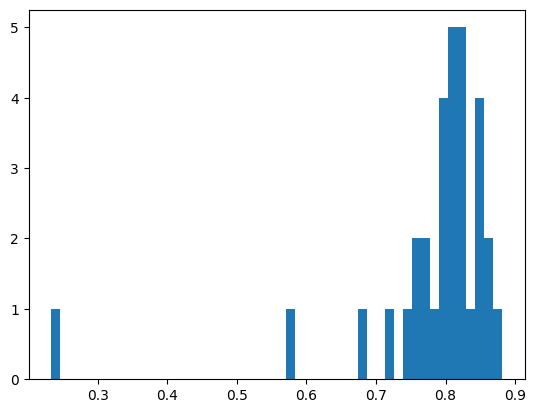

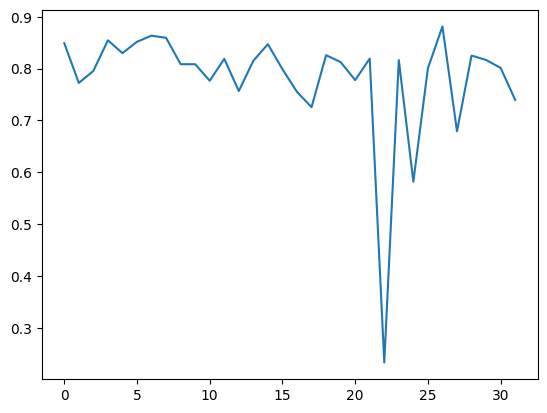

(22, 26)

In [22]:
plt.hist(MIs, bins=50)
plt.show()
plt.plot(MIs)
plt.show()
np.argmin(MIs), np.argmax(MIs)

In [15]:
h = np.concatenate(hout, axis=0)
hvar = [h[:, i].var() for i in range(h.shape[1])] # Task Variance
hvar = np.array(hvar)

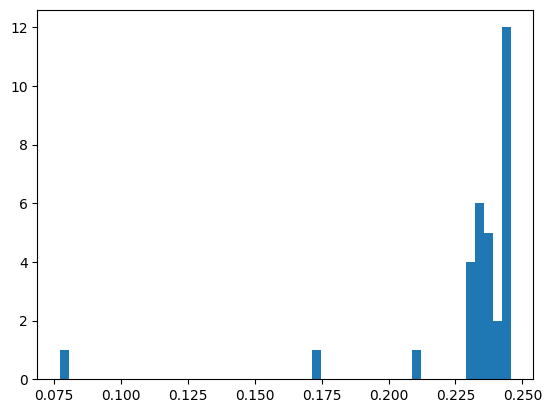

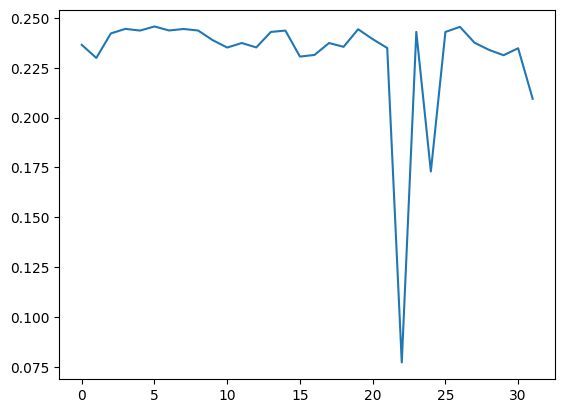

(22, 5)

In [16]:
plt.hist(hvar, bins=50)
plt.show()
plt.plot(hvar)
plt.show()
np.argmin(hvar), np.argmax(hvar)

In [17]:
b = model.fc3.bias.data.cpu().numpy()
W = model.fc3.weight.data.cpu().numpy()
B = np.tile(b/W.shape[1], (W.shape[1],1)).T # 认为每条连接对bias的贡献相同
b_ = B / W
b_ = b_.sum(axis=0)

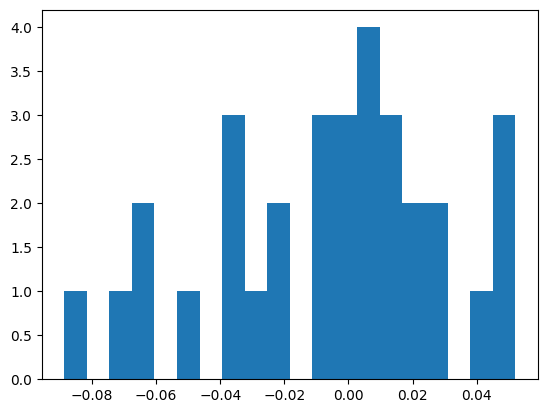

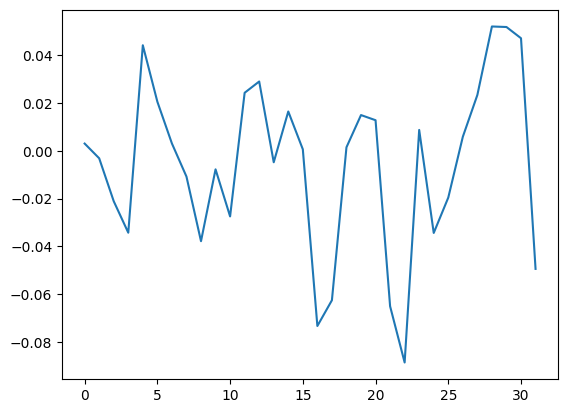

(22, 28)

In [18]:
plt.hist(b_, bins=20)
plt.show()
plt.plot(b_)
plt.show()
b_.argmin(), b_.argmax()

In [19]:
from scipy import stats
# 斯皮尔曼相关系数，皮尔逊相关系数
stats.spearmanr(MIs, hvar), stats.pearsonr(MIs, hvar), \
stats.spearmanr(MIs, b_), stats.pearsonr(MIs, b_), \
stats.spearmanr(hvar, b_), stats.pearsonr(hvar, b_)
# 说明互信息、TV、bias之间有着强相关性

(SignificanceResult(statistic=0.6612903225806451, pvalue=3.7792302156202e-05),
 PearsonRResult(statistic=0.9486604845330491, pvalue=1.5274698226329905e-16),
 SignificanceResult(statistic=0.3673020527859237, pvalue=0.03863815357605586),
 PearsonRResult(statistic=0.49342683973825396, pvalue=0.00410832082206002),
 SignificanceResult(statistic=0.20234604105571843, pvalue=0.26672380517961103),
 PearsonRResult(statistic=0.47247309517342545, pvalue=0.006323307756504479))

In [20]:
# 不同个数神经元与最终输出的互信息变化
MIss = [MIxy([i for i in range(j)]) for j in range(1, hout01[0].shape[1]+1)]
MIss = np.array(MIss)
plt.plot(MIss)
plt.show()